In [33]:
import pennylane as qml
from pennylane import numpy as np

from tqdm import tqdm
from IPython.display import clear_output

import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
import cv2
from functools import reduce
import pickle
import pandas as pd

In [211]:
from torchvision import datasets, transforms
# 1. 데이터 불러오기
train_data = datasets.MNIST(root='./data/02/', train=True, download=True)
test_data = datasets.MNIST(root='./data/02/', train=False, download=True)
x_train = train_data.data.numpy()
y_train = train_data.targets.numpy()
x_test = test_data.data.numpy()
y_test = test_data.targets.numpy()
print('====전처리 이전=====')
print('number of training data : ', x_train.shape, y_train.shape)
print('number of test data : ', x_test.shape, y_test.shape)

#######
train_size = 1000
imgw = 16
#######

# 0만 고른다
GENERATING_NUMBER = 1
x_train_origin = x_train[y_train == GENERATING_NUMBER]
x_train_origin = x_train_origin[:train_size]
x_test_origin = x_test[y_test == GENERATING_NUMBER]
x_train_origin, x_test_origin = x_train_origin/255.0, x_test_origin/255.0


# 4x4로 resize
x_train = np.array([cv2.resize(img, dsize=(imgw, imgw)) for img in x_train_origin])
x_test = np.array([cv2.resize(img, dsize=(imgw, imgw)) for img in x_test_origin])

# 최대값 1로 고정
# add noise
x_train = x_train + np.random.normal(0, 0.1, size=x_train.shape)
x_train = x_train / np.max(x_train, axis=(1, 2), keepdims=True)
x_test = x_test / np.max(x_test, axis=(1, 2), keepdims=True)

print("train shape = ", x_train.shape)
print("test shape = ", x_test.shape)

====전처리 이전=====
number of training data :  (60000, 28, 28) (60000,)
number of test data :  (10000, 28, 28) (10000,)
train shape =  (1000, 16, 16)
test shape =  (1135, 16, 16)


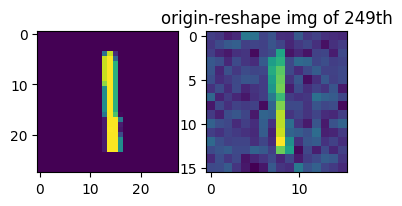

In [212]:
# Importing the required library
import matplotlib.pyplot as plt

# Creating a figure with two subplots
fig, axs = plt.subplots(1,2, figsize=(4, 8))
t = np.random.randint(0, train_size)
axs[0].imshow(x_train_origin[t])
axs[1].imshow(x_train[t])
plt.title(f'origin-reshape img of {t}th')
plt.show()

In [222]:
noise_qubits = 7
code_qubits = 2
output_qubits = 8
n_qubits = noise_qubits + code_qubits
assert(output_qubits <= n_qubits) # 출력 큐빗은 noise qubit이하여야 한다.

n_layers = 20
BATCH_SIZE = 16
print("n_qubits = {} n_layers = {}".format(n_qubits, n_layers))

dev = qml.device("default.qubit", wires=n_qubits)

random_indices = np.random.choice(2**n_qubits, 2 * (2**output_qubits), replace=False)
mask = np.zeros(2**n_qubits, dtype=bool)
mask_inv = np.zeros(2**n_qubits, dtype=bool)
mask[random_indices[:len(random_indices)//2]] = True # amplitude embedding에 사용할 위치는 랜덤하게 고른다.
mask_inv[random_indices[len(random_indices)//2:]] = True

n_qubits = 9 n_layers = 20


In [223]:
coeff = 0.2

def generator_init(generator_input):
    for i in range(n_qubits):
        qml.RY(generator_input[i]*np.pi/2, wires=i) # TODO: *a 해서 값 범위 맞추기

def generator_layer(params):
    for i in range(n_qubits):
        qml.RX(params[i][0], wires=i)
        qml.RY(params[i][1], wires=i)
        qml.RZ(params[i][2], wires=i)
    
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1)%n_qubits])

@qml.qnode(dev, interface="torch")
def generator_circuit(params, generator_input):
    """
    quantum circuit nodeq1
    generator_input (np.array(큐빗)) : 생성기 입력 seed (noise + code)
    params (torch.Tensor(레이어,큐빗,3)): a parameter
    마지막 측정은 모두 Z로
    """

    generator_init(generator_input)

    for param in params:
        generator_layer(param)

    return qml.probs(wires=range(n_qubits))

def generator_forward(params, generator_input):
    # 제너레이터 돌리고 결과 return하는 함수
    generator_output = [generator_circuit(params, single_in) for single_in in generator_input] # (BATCH_SIZE, 2**n_qubits) 차원
    generator_output = torch.stack(generator_output) # (BATCH_SIZE, 2**n_qubits) 차원

    output = generator_output[:, mask]
    output /= generator_output.sum(dim=1, keepdim=True) # (BATCH_SIZE, n_qubits) 차원
    # 곱하기 2 해서 범위를 초과하게 만들음
    #output = generator_output[:, mask] / generator_output[:, mask_inv]
    #output[output <= output.mean()] = 0
    
    output = output / output.max(dim=1, keepdim=True)[0]

    return output, generator_output[:, -code_qubits:] # noise, code 순서로 반환


def generator_train_step(params, generator_input, use_mine = False, _qmine = False):
    '''
    params (torch.Tensor(레이어,큐빗,3)): a parameter
    generator_input (torch.Tensor(BATCH_SIZE, n_qubits)): 생성기 입력 seed (noise + code). -1~1 사이의 값
    '''
    code_input = generator_input[:, -code_qubits:] # 입력중에서 code만 뽑는다. (BATCH_SIZE, code_qubits)

    generator_output, code_output = generator_forward(params, generator_input) # 출력을 뽑아낸다
    generator_output = generator_output.to(torch.float32) # (BATCH_SIZE, output_qubits)
    
    disc_output = discriminator(generator_output) # 밑에 코드에서 정의됨
    gan_loss = torch.log(1-disc_output).mean()
    # print("gan_loss = ", gan_loss, gan_loss.shape)
    
    t = (code_input - code_output).pow(2).mean()

    if use_mine:
        pred_xy = mine(code_input, generator_output)
        code_input_shuffle = code_input[torch.randperm(BATCH_SIZE)]
        pred_x_y = mine(code_input_shuffle, generator_output)
        mi = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        gan_loss -= coeff * mi

    elif _qmine:
        gan_loss += 0 # TODO: qmine loss 추가하기

    return generator_output, gan_loss+t*0, gan_loss, t # TODO: 이건 분석용으로 넣어놓음.지워야 함.


def prediction(params, image, debug=False):
    prob_0 = 0
    prob_1 = 0
    for i in range(n_layers):
        prob_0 += circuit(params[:i+1], (image, 0))
        prob_1 += circuit(params[:i+1], (image, 1))

    if (debug):
        return (int(prob_0 <= prob_1), prob_0, prob_1)
    return int(prob_0 <= prob_1)

In [224]:
import torch.nn as nn
from torch.nn import functional as F

class LinearDiscriminator(nn.Module):
    def __init__(self, input_dim=2**output_qubits):
        super().__init__()
        self.hidden_size = 50
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, 1),
            nn.Sigmoid())

        self.input_dim = input_dim

    def forward(self, x):
        if(len(x.shape) != 2):
            x = x.view(x.shape[0], -1)

        return self.layers(x)


class LinearMine(nn.Module):
    def __init__(self):
        super(LinearMine, self).__init__()
        H = 20
        self.fc1 = nn.Linear(code_qubits, H)
        self.fc2 = nn.Linear(2**output_qubits, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2

disc_loss_fn = nn.BCELoss()
def disc_cost_fn(real_input, fake_input, smoothing=False):
    batch_num = real_input.shape[0]
    disc_real = discriminator(real_input)
    disc_fake = discriminator(fake_input)

    real_label = torch.ones((batch_num, 1))
    fake_label = torch.zeros((batch_num, 1))
    
    if smoothing:
        real_label = real_label - 0.2*torch.rand(real_label.shape).to(device)
    
    loss = 0.5 * (disc_loss_fn(disc_real, real_label) + disc_loss_fn(disc_fake, fake_label))
    
    return loss


In [225]:
G_lr = 1e-3
D_lr = 1e-4
M_lr = 1e-3
use_mine = False
use_qmine = False

generator_params = Variable(torch.tensor(np.random.normal(-np.pi, np.pi, (n_layers, n_qubits, 3))), requires_grad=True)
print("parameter shape: ", generator_params.shape)

discriminator = LinearDiscriminator()
mine = LinearMine()

G_opt = torch.optim.Adam([generator_params], lr=G_lr)
D_opt = torch.optim.Adam(discriminator.parameters(), lr=D_lr)
M_opt = torch.optim.Adam(mine.parameters(), lr=M_lr)

#G_scheduler = torch.optim.lr_scheduler.StepLR(G_opt, step_size=30, gamma=0.7)
#D_scheduler = torch.optim.lr_scheduler.StepLR(D_opt, step_size=30, gamma=0.85)
#M_scheduler = torch.optim.lr_scheduler.StepLR(M_opt, step_size=30, gamma=0.7)

parameter shape:  torch.Size([20, 9, 3])


In [226]:
import os
title = f'try6_{use_mine}'
folder_paths = [f'result/{title}', f'result/{title}/savepoints', f'result/{title}/graphs', f'result/{title}/samples']
for path in folder_paths:
    if not os.path.exists(path):
        os.makedirs(path)
    
with open(f'result/{title}/param.txt', 'w') as f:
    f.write('G_lr = {}\n'.format(G_lr))
    f.write('D_lr = {}\n'.format(D_lr))
    f.write('M_lr = {}\n'.format(M_lr))
    #f.write('G_scheduler: step={}, gamma={}\n'.format(G_scheduler.step_size, G_scheduler.gamma))
    #f.write('D_scheduler: step={}, gamma={}\n'.format(D_scheduler.step_size, D_scheduler.gamma))
    #f.write('M_scheduler: step={}, gamma={}\n'.format(M_scheduler.step_size, M_scheduler.gamma))
    f.write('coeff = {}\n'.format(coeff))
    f.write('use_mine = {}\n'.format(use_mine))
    f.write('use_qmine = {}\n'.format(use_qmine))
    f.write('n_qubits = {}\n'.format(n_qubits))
    f.write('output_qubits = {}\n'.format(output_qubits))
    f.write('code_qubits = {}\n'.format(code_qubits))
    f.write('n_layers = {}\n'.format(n_layers))
    f.write('param shape = {}\n'.format(generator_params.shape))

In [227]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def visualize_output(log_gen_outputs, log_gen_codes, title, rep, recorder):

    # 이미지 리스트에서 랜덤하게 8개 이미지 선택
    num_images = 8
    image_list = log_gen_outputs
    image_indices = np.random.choice(len(image_list), num_images, replace=False)
    selected_images = [image_list[i] for i in image_indices]

    # 선택된 이미지를 8x8 크기로 reshape
    reshaped_images = [image.reshape(imgw, imgw) for image in selected_images]

    # 이미지를 2x4 배치로 그리기 위한 그리드 설정
    grid_rows = 2
    grid_cols = 4
    gs = GridSpec(grid_rows, grid_cols)

    # 이미지를 그리드에 배치하고 시각화
    plt.figure(figsize=(10, 6))
    for i, image in enumerate(reshaped_images):
        row = i // grid_cols
        col = i % grid_cols
        ax = plt.subplot(gs[row, col])
        ax.imshow(image)  # 이미지를 회색조로 표시
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle(f"Epoch {rep}, random imgs", fontsize=16)
    plt.savefig(f'result/{title}/samples/{rep}.png')
    plt.show()

    
    plt.figure()
    plt.plot(recorder['g_loss'], label='g_loss', marker='o')
    plt.plot(recorder['d_loss'], label='d_loss', marker='o')
    plt.plot(recorder['mi'], label='mi', marker='o')
    plt.legend()
    plt.title(f'Epoch {rep}, loss graph')
    plt.savefig(f'result/{title}/graphs/{rep}.png')
    plt.show()
    

In [228]:
epoch = 300

recorder_keywords = ['d_loss', 'g_loss', 'a_loss', 'b_loss', 'mi']
recorder = {k: [] for k in recorder_keywords}
final_rep = 0

for rep in range(1, epoch+1):
    np.random.shuffle(x_train)
    iter_num = int(len(x_train) * 0.5 //BATCH_SIZE) # 매번 50% 추출해서 학습. 셔플하니까 자투리 생기는건 무시.
    
    G_loss_sum = 0.0
    D_loss_sum = 0.0
    a_loss_sum = 0.0
    b_loss_sum = 0.0
    mi_sum = 0.0
    log_gen_outputs = []
    log_gen_codes = []
    pbar = tqdm(range(iter_num))
    
    for i in pbar:
        batch = torch.FloatTensor(x_train[BATCH_SIZE * i : BATCH_SIZE * i + BATCH_SIZE])
        
        # train generator
        generator_seed = torch.rand((BATCH_SIZE, n_qubits)) * 2 - 1
        generator_output, generator_loss, a, b = generator_train_step(generator_params, generator_seed, use_mine=use_mine, _qmine=use_qmine)
        G_opt.zero_grad()
        generator_loss.requires_grad_(True)
        generator_loss.backward()
        G_opt.step()
        a_loss_sum += a.detach().numpy()
        b_loss_sum += b.detach().numpy()

        # train discriminator
        fake_input = generator_output.detach().to(torch.float32)
        disc_loss = disc_cost_fn(batch.reshape(-1, imgw**2), fake_input, smoothing=False)
        D_opt.zero_grad()
        disc_loss.requires_grad_(True)
        disc_loss.backward()
        D_opt.step()

        # train mine
        code_input = generator_seed[:, -code_qubits:] 
        pred_xy = mine(code_input, fake_input)
        code_input_shuffle = code_input[torch.randperm(BATCH_SIZE)]
        pred_x_y = mine(code_input_shuffle, fake_input)
        mi = -torch.mean(pred_xy) + torch.log(torch.mean(torch.exp(pred_x_y)))
        M_opt.zero_grad()
        mi.requires_grad_(True)
        mi.backward()
        M_opt.step()


        D_loss_sum += disc_loss.item()
        G_loss_sum += generator_loss.item()
        mi_sum -= mi.item() # (-1)곱해져 있어서 빼야함.
        a_loss_sum += a.item()
        b_loss_sum += b.item()

        pbar.set_postfix({'G_loss': G_loss_sum/(i+1), 'D_loss': D_loss_sum/(i+1), 'MI': mi_sum/(i+1)})
        log_gen_outputs.append(fake_input.numpy())
        log_gen_codes.append(code_input.numpy())

    G_scheduler.step()
    D_scheduler.step()
    M_scheduler.step()

    recorder['d_loss'].append(D_loss_sum/iter_num)
    recorder['g_loss'].append(G_loss_sum/iter_num)
    recorder['a_loss'].append(a_loss_sum/iter_num)
    recorder['b_loss'].append(b_loss_sum/iter_num)
    recorder['mi'].append(mi_sum/iter_num)
    
    log_gen_outputs = np.concatenate(log_gen_outputs, axis=0)
    log_gen_codes = np.concatenate(log_gen_codes, axis=0)
    print("epoch: {}, D_loss: {}, G_loss: {}, MI = {}".format(rep, D_loss_sum/iter_num, G_loss_sum/iter_num, mi_sum/iter_num))
    print("a_loss: {}, b_loss: {}".format(a_loss_sum, b_loss_sum))

    visualize_output(log_gen_outputs, log_gen_codes, title, rep, recorder)

    with open(f'result/{title}/savepoints/discriminator_{rep}.pkl', 'wb') as file:
        pickle.dump(discriminator, file)
    with open(f'result/{title}/savepoints/generator_{rep}.pkl', 'wb') as file:
        pickle.dump(generator_params, file)

    final_rep = rep

  0%|          | 0/31 [00:00<?, ?it/s]

In [187]:
import openpyxl
df = pd.DataFrame(recorder)
output_filename = f'result/{title}/recorder.xlsx'
df.to_excel(output_filename, index=False)